# LiDAR (Light Detection And Ranging)

### Point Cloud
- 3차원 공간상에 퍼져 있는 여러 포인트(Point)의 집합(set cloud)
- RGB-D 센서로부터 3차원 도트 이미지를 얻을 수 있음 -> Depth
- LiDAR 센서로부터 얻은 것은 흑백 이미지

### Point Net 실습

In [1]:
# trimesh -> 3차원 삼각 메시
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.9/695.9 kB 5.9 MB/s eta 0:00:00


In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [3]:
import os
import glob
import trimesh
import numpy as np
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)

### 데이터셋 로드
- 케라스에 있음
- PC 연구에 쓰이는 ModelNet 데이터셋을 활용
- ModelNet40보다 작은 ModelNet10을 활용

In [4]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


### 가시화
- .off 메쉬 파일을 trimesh 패키지로 가시화

In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

### Mesh2PC
- 메쉬 데이터를 포인트 클라우드로 변환하기 위해서는 메쉬 표면을 샘플링 해야 한다.

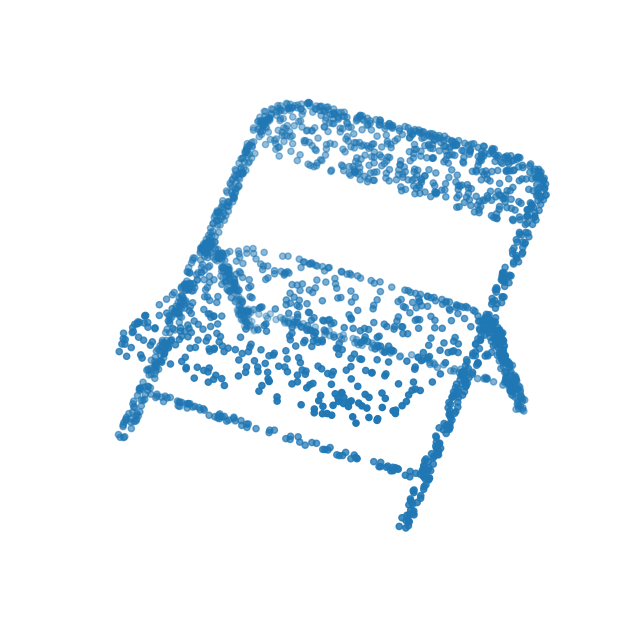

In [6]:
point = mesh.sample(2048)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(point[:, 0], point[:, 1], point[:, 2])
ax.set_axis_off()
plt.show()

In [7]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [17]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: monitor
processing class: toilet
processing class: bathtub
processing class: desk
processing class: night_stand
processing class: dresser
processing class: bed
processing class: chair
processing class: table
processing class: sofa


In [18]:
def augment(points, label) :

    # gitter points
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype="float64")

    # shuffle points
    points = keras.random.shuffle(points)

    return points, label

train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

### 모델 정의

In [19]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

### 세부 아키텍처

In [20]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))

In [21]:
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [22]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)

x = conv_bn(x, 32)
x = conv_bn(x, 32)

x = tnet(x, 32)

x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)

x = layers.GlobalMaxPooling1D()(x)

x = dense_bn(x, 256)

x = layers.Dropout(0.3)(x)

x = dense_bn(x, 128)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 2048, 32)       │            128 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 2048, 32)       │            128 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 2048, 32)       │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 2048, 64)       │          2,112 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 2048, 64)       │            256 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 2048, 64)       │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 2048, 512)      │         33,280 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 2048, 512)      │          2,048 │ conv1d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 2048, 512)      │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 512)            │              0 │ activation_19[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        131,328 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 256)            │          1,024 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 256)            │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)     

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [23]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 266ms/step - loss: 45.7765 - sparse_categorical_accuracy: 0.2214 - val_loss: 86.8561 - val_sparse_categorical_accuracy: 0.2478
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 36.3474 - sparse_categorical_accuracy: 0.3285 - val_loss: 138493946757120.0000 - val_sparse_categorical_accuracy: 0.3855
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - loss: 36.2019 - sparse_categorical_accuracy: 0.3191 - val_loss: 187272284602368.0000 - val_sparse_categorical_accuracy: 0.2929
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 35.9258 - sparse_categorical_accuracy: 0.3553 - val_loss: 5442370466096248520704.0000 - val_sparse_categorical_accuracy: 0.4731
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 35.9309 - sparse_categorical_accuracy: 0.3830 - val_loss: 107226057567895552.0000 - val_sparse_categorical_accuracy: 0.4143
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - loss: 35.8216 - sparse_cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


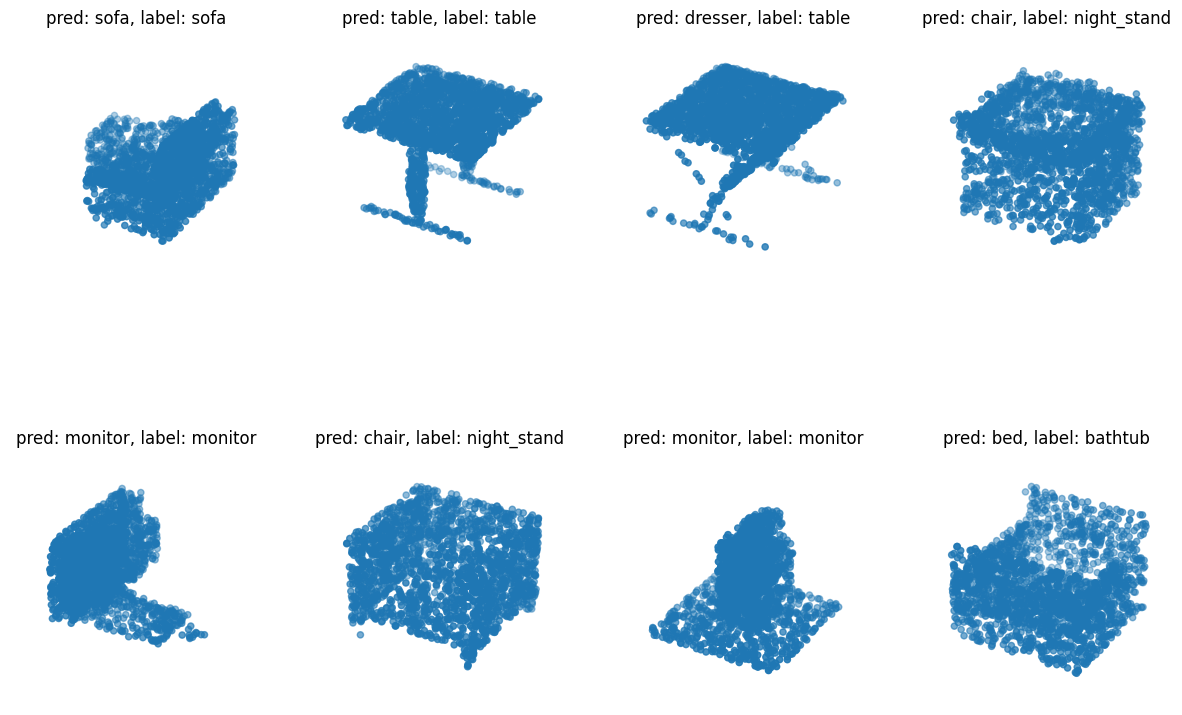

In [24]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

# ROS


## Catkin 설정
- ROS에서 다양한 프로그램(실행 프로그램, 라이브러리, 스크립트 등)을 사용하기 위한 빌드시스템